# Descripción

Este notebook contiene los pasos requeridos para asignar las combinaciones, previamente asignadas, profesor-curso a un salón de acuerdo a los requerimientos institucionales.

In [1]:
import json

# READ DATA

## first stage model output

In [2]:
# basic parameters
DAY_LENGTH=16

# Horizonte de planificación
HORIZON=5

#  Días de la semana
DAYS=['Lunes','Martes','Miercoles','Jueves','Viernes']


In [3]:
# Este diccionario contiene un mapa de los slots de tiempo a los días y horas

actual_time={}
for d in range(HORIZON):
    for h in range(DAY_LENGTH):
        actual_time[d*16+h]={"slot":DAYS[d]+' '+str(h+6)+':00', "day":d, "hour":h,'slot_abr':DAYS[d][0]+str(h)}

In [4]:
# read model_output.json
allocations=json.load(open('data/model_output_2.json','r'))
#allocations

In [5]:
groups=allocations['courses']
teachers=allocations['teachers']
pairs=allocations['ensembles']
teachers=set([int(t) for t in teachers])
groups=set([g for g in groups])
pairs=[(int(p[0]) ,p[1]) for p in pairs]

In [6]:
pairs_dict={j:i for i,j in pairs}


In [7]:
courses_by_teacher={}
for p in pairs:
    if p[0] not in courses_by_teacher:
        courses_by_teacher[p[0]]=[p[1]]
    else:
        courses_by_teacher[p[0]].append(p[1])

# teachers by course
teachers_by_course={}
for p in pairs:
   teachers_by_course[p[1]]=p[0]




## Initial data load

In [8]:
# read data.json
horas_curso=json.load(open('data/horas_curso.json','r'))
grupo_requerimiento=json.load(open('data/grupo_requerimiento.json','r'))
ubicacion_semestral=json.load(open('data/ubicacion_semestral.json','r'))
disponibilidad_docentes=json.load(open('data/disponibilidad.json','r'))

In [9]:
tipo_salon={'A','B','C','D','E','F','G'}
hora_disponibilidad_x_salon={
    'A':10
    ,'B':0
    ,'C':0
    ,'D':10
    ,'E':10
    ,'F':10
    ,'G':10
}

cantidad_de_salones={
 'A':11
 ,'B':9
 ,'C':3
 ,'D':1
 ,'E':1
 ,'F':2
 ,'G':1   
}



salas_de_inform={"C","D"}

clases_sala_infor={
    "2027-0059",
    "9937-0012",
    "6612-0001",
    "8830-0008",
    "8837-0021",
    "8830-0006",
    "9937-0013",
    "6611-0088",
    "8827-0008",
    "8830-0009",
    "6069-0018",
    "6069-0127",
    "9937-0014",
    "8821-0010",
    "9937-0018"
    
}



In [10]:
names={326151: 'Alvaro Jose Torres Penagos',
336392:	'Andres Felipe Hernandez Giraldo',
183645:	'Andres Felipe Parra Perea',
274691:	'Beatriz Elena Hernandez Arias',
259554:	'Claudia Orly Escudero Jimenez',
331121:	'Edwin Fernando Restrepo Salazar',
219830:	'Edwin Javier Ortega Zuñiga',
187061:	'Jairo Arboleda Zuñiga',
277461:	'Mariela Galindo',
226130:	'Pedro Nel Barbosa Garcia',
226130:	'Ruben Dario Parra Zuleta',
182876:	'William Andres Alzate Cobo',
404903: 'Yaqueline_Quiñones_Rodriguez', 
284431: 'Marino_Renjifo', 
234531: 'Marcelo_antonioni_Aguilar_Montero', 
170520: 'Pedro_Nel_Barbosa_Garcia'}

# Modelo

In [11]:
I=set(teachers)
J=set(groups)
K=set(pairs)
C= tipo_salon

In [12]:
from itertools import product

# courses that are the same
same_course={}
# courses that are taught by the same teacher
same_teacher={}

# delta semestres
delta_semestre={}
for j1,j2 in product(J,J):
    same_course[(j1,j2)]=0
    same_teacher[(j1,j2)]=0
    if j1[:9]==j2[:9]:
        same_course[(j1,j2)]=1
    delta_semestre[(j1,j2)]=(9-abs(ubicacion_semestral[j1[:9]]["Semestre"]-ubicacion_semestral[j2[:9]]["Semestre"]))

sets_of_courses=[]
for p in pairs:
    for p2 in pairs:
        if p[0]==p2[0]:
            same_teacher[(p[1],p2[1])]=1
            sets_of_courses.append(set([p[1],p2[1]]))
# merge sets of courses when they have a common course
for i in range(len(sets_of_courses)):
    for j in range(i+1,len(sets_of_courses)):
        if len(sets_of_courses[i].intersection(sets_of_courses[j]))>0:
            sets_of_courses[i]=sets_of_courses[i].union(sets_of_courses[j])
            sets_of_courses[j]=set()
# remove empty sets
sets_of_courses=[s for s in sets_of_courses if len(s)>0]


# course and time slot compatibility
time_compatibility={}
for c,j in product(C,J):
    for s in actual_time.keys():
        time_compatibility[(c,j,s)]=0
        if actual_time[s]['hour'] + horas_curso[j[:9]]['horas']-1<DAY_LENGTH:
            time_compatibility[(c,j,s)]=1

print(disponibilidad_docentes)
valid_keys=[]
for c,j,s in product(C,J,actual_time.keys()):
    if time_compatibility[(c,j,s)]==1 and s in disponibilidad_docentes[str(teachers_by_course[j])]:
        valid_keys.append((c,j,s))



{'326151': [3, 4, 5, 6, 8, 9, 10, 11, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 36, 37, 38, 39, 40, 43, 44, 60, 61, 62, 63, 64, 65, 66, 76, 77, 78, 79, 80, 81, 82, 83], '336392': [3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 28, 29, 30, 31, 32, 38, 39, 43, 44, 45, 46, 47, 48, 49, 54, 55, 56, 59, 60, 61, 62, 63, 79, 80, 81, 82, 83], '183645': [2, 3, 4, 5, 6, 9, 10, 11, 12, 25, 26, 27, 28, 29, 30, 31, 32, 43, 44, 45, 46, 47, 48, 49, 55, 56, 59, 60, 61, 62, 77, 78, 79, 80, 81, 82, 87, 88, 89, 90], '274691': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23, 28, 29, 30, 31, 32, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83], '259554': [7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 23, 29, 30, 31, 32, 42, 43, 44, 45, 46, 47, 48, 49, 61, 62, 63, 64, 65, 66, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92], '331121': [7, 8, 9, 10, 11, 12, 13, 14, 15, 29, 30, 31, 32, 42, 43, 44, 45, 46, 59, 60, 61, 62, 63, 64, 75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92]

In [13]:
import gurobipy as gp

# declare an empty model
m=gp.Model('Asignacion de salones')
m.setParam('OutputFlag',False)



# declares variables

# y representa si el cursu j se asigna a un salón tipo c iniciando en el slot s
y=m.addVars(valid_keys,vtype=gp.GRB.BINARY,name='y')
# x representa si el curso j ocupa un salón tipo c durante el slot s
x=m.addVars([(c,j,s) for c in C for j in J for s in actual_time.keys()],vtype=gp.GRB.BINARY,name='x')
# indica si dos cursos se solapan en algún momento
z=m.addVars([(j1,j2) for j1,j2 in product(J,J) if j1!=j2],vtype=gp.GRB.BINARY,name='z')
# classroooms
req_rooms=m.addVars(C,vtype=gp.GRB.INTEGER,name='req_rooms')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-04


Restricción 1: Todos los cursos deben tener exactamente una asignación de inicio.

$\sum_{c,j1,s \in \text{{valid\_keys}}, j1=j} y[(c,j1,s)] = 1 \quad \forall j \in J$


In [14]:
# each course starts at one time slot
m.addConstrs((gp.quicksum(y[(c,j1,s)] for c,j1,s in valid_keys if j1==j)==1 for j in J),name='each_course_starts_at_one_time_slot')
0

0

Restricción 2:

si un curso da inicio durante el slot s en el salón tipo c, y tiene una duración t, ese curso debe estar ocupando un slot entre s, s+1 hasta s+t-1

$  
\sum_{s1 \in \text{{range}}(s,s+\text{{horas\_curso}}[j1[:9]]['horas']) \atop (c,j1,s1) \in \text{{valid\_keys}}} x[(c,j1,s1)] \geq y[(c,j1,s)] \cdot \text{{horas\_curso}}[j1[:9]]['horas'] \forall c, j1, s \in \text{{valid\_keys}}
$

In [15]:
"""cont=0
for c,j1,s in valid_keys:
    lhs=gp.quicksum(x[(c,j1,s1)] for s1 in range(s,s+horas_curso[j1[:9]]['horas']) )
    rhs=y[(c,j1,s)]*horas_curso[j1[:9]]['horas']
    print(lhs,">=",rhs)
    cont+=1
    if cont==16:
        break"""
    

m.addConstrs((gp.quicksum(x[(c,j1,s1)] for s1 in range(s,s+horas_curso[j1[:9]]['horas'])  )
             >=y[(c,j1,s)]*horas_curso[j1[:9]]['horas'] for c,j1,s in valid_keys))
0

0

Restricción 3:
Cada curso es asignado un bloque de tiempo equivalente a las horas que requiere


$ \sum_{c,j1,s \in \text{{valid\_keys}} \atop j1=j} x[(c,j1,s)] = \text{{horas\_curso}}[j[:9]]['horas'] \forall j \in J$



In [16]:
m.addConstrs((gp.quicksum(x[(c,j1,s)] for c,j1,s in valid_keys if j1==j)==horas_curso[j[:9]]['horas'] for j in J),name='each_course_is_assigned_the_time_it_requires')
0

0

$\forall j1, j2 \in J \quad \text{{s.t.}} \quad j1 \neq j2, \forall c1, c2 \in C, \forall s \in \text{{actual\_time.keys()}}, z[j1,j2] \geq x[c1,j1,s] + x[c2,j2,s] - 1$


In [17]:
m.addConstrs((z[j1,j2]>=x[c1,j1,s]+x[c2,j2,s]-1 for j1,j2 in product(J,J) if j1!=j2 for c1 ,c2 in product(C,C) for s in actual_time.keys()),name='si_dos_cursos_se_imparten_a_la_misma_hora_en_cualquier_salon_se_debe_activar_la_variable_z_que_lleva_cuentas_de_los_solapamientos')
0

0

In [18]:
m.addConstrs((gp.quicksum(x[(c,j,s)] for j in J )<=req_rooms[c]  for c in C for s in actual_time.keys()),name='required_rooms_of_each_type')

m.addConstrs((req_rooms[c] <=cantidad_de_salones[c]  for c in C for s in actual_time.keys()),name='cada_curso_se_imparte_en_un_maximo_de_un_salon_de_cada_tipo')
0


0

In [19]:
# si el salón requiere sala de sistemas, se debe programar en una de las salas de sistemas {"C","D"}

m.addConstrs((gp.quicksum(y[(c,j,s)] for c in salas_de_inform for s in actual_time.keys() if (c,j,s) in valid_keys)==1 for j in J if j[:9] in clases_sala_infor ),name='si_el_curso_requiere_sala_de_sistemas_se_debe_programar_en_una_de_las_salas_de_sistemas')
m.addConstrs((gp.quicksum(y[(c,j,s)] for c in salas_de_inform for s in actual_time.keys() if (c,j,s) in valid_keys)==0 for j in J if not( j[:9] in clases_sala_infor) ),name='si_el_curso_requiere_sala_de_sistemas_se_debe_programar_en_una_de_las_salas_de_sistemas')
0

0

In [20]:
# una clase no puede empezar en un slot si no está aún disponible el salón
m.addConstrs((y[(c,j,s)]==0 for c,j,s in valid_keys if actual_time[s]['hour']<hora_disponibilidad_x_salon[c]),name='una_clase_no_puede_empezar_en_un_slot_si_no_esta_aun_disponible_el_salon')
0

0

In [21]:
# two courses belonging to the same set cannot be scheduled at the same time
m.addConstrs((gp.quicksum(x[(c,j1,s)] for j1 in sets_of_courses[i] if (c,j1,s) in valid_keys)<=1 for i in range(len(sets_of_courses)) for c in C for s in actual_time.keys()), name='c1') 
0

0

In [22]:
# two classes with the same code cannot take place simultaneously
m.addConstrs((y[(c1,j1,s1)]+y[(c2,j2,s2)]<=1 for (c1,j1,s1) in valid_keys for (c2,j2,s2) in valid_keys if c1==c2 and s1==s2 and j1[:9]==j2[:9] and j1!=j2), name='one_class')
m.addConstrs((x[(c1,j1,s1)]+x[(c2,j2,s2)]<=1 for (c1,j1,s1) in valid_keys for (c2,j2,s2) in valid_keys if c1==c2 and s1==s2 and j1[:9]==j2[:9] and j1!=j2), name='one_class_2')
0

0

In [23]:
m.addConstrs((z[j1,j2]==0 for j1,j2 in product(J,J) if ubicacion_semestral[j1[:9]]["Semestre"]==ubicacion_semestral[j2[:9]]["Semestre"] and j1!=j2), name='delta_semestre')
#m.addConstrs((z[j1,j2]==0 for j1,j2 in product(J,J) if abs(ubicacion_semestral[j1[:9]]["Semestre"]-ubicacion_semestral[j2[:9]]["Semestre"])==1 and j1!=j2), name='delta_semestre_2')
0

0

El objetivo es generar una programación tal que los cursos de semestres similares se
programan en diferentes momentos del día. Es decir, queremos maximizar la diferencia de semestre entre los cursos que se deban programar a la misma hora.

$ \max:\sum_{{j1,j2 \in J, j1 \neq j2}} z[j1,j2] \cdot \delta_{\text{{semestre}}}[j1,j2]$


In [24]:
m.update()

# save guroby model
m.write('modelo.mps')
# save guroby model to pickle


In [64]:
# funcion objetivo:
# maximizar la suma de los deltas semestrales de los cursos que se imparten
obj_1=gp.quicksum(z[j1,j2]*delta_semestre[j1,j2] for j1,j2 in product(J,J) if j1!=j2) 
obj_2=gp.quicksum(req_rooms[c]*(16-hora_disponibilidad_x_salon[c]) for c in C)
obj_3=gp.quicksum(z[j1,j2]*delta_semestre[j1,j2]**2 for j1,j2 in product(J,J) if j1!=j2) 
obj_4=gp.quicksum(z[j1,j2]*1 for j1,j2 in product(J,J) if j1!=j2 and delta_semestre[j1,j2]>=8)

# the obj 4 replaces delta_semestre with 1 if delta_semestre[j1,j2] is 8 or more



In [26]:
# model sense
m.modelSense=gp.GRB.MINIMIZE
m.setObjective(obj_2)
m.optimize()
print(m.status)


2


In [27]:

m.addConstrs((req_rooms[c] <=int(req_rooms[c].x)  for c in C for s in actual_time.keys()),name='max number of rooms')
m.modelSense=gp.GRB.MINIMIZE


In [28]:
baseline={c:req_rooms[c].x for c in C}
baseline

{'G': 1.0, 'F': 1.0, 'C': 1.0, 'A': 0.0, 'D': 0.0, 'E': 0.0, 'B': 1.0}

In [29]:
#retrieve the constraints based in the name

"""print(f"objective value before modifcation: {m.objVal}")
salones={"F","C","E","G"}
for sal in salones:
    for s in actual_time.keys():
        #print(m.getConstrByName('max number of rooms['+'A'+','+str(s)+']'))
        # modify the constraint
        m.getConstrByName('max number of rooms['+sal+','+str(s)+']').rhs=baseline[sal]+1

m.update()
m.optimize()
print(f"objective value after modifcation: {m.objVal}")"""


'print(f"objective value before modifcation: {m.objVal}")\nsalones={"F","C","E","G"}\nfor sal in salones:\n    for s in actual_time.keys():\n        #print(m.getConstrByName(\'max number of rooms[\'+\'A\'+\',\'+str(s)+\']\'))\n        # modify the constraint\n        m.getConstrByName(\'max number of rooms[\'+sal+\',\'+str(s)+\']\').rhs=baseline[sal]+1\n\nm.update()\nm.optimize()\nprint(f"objective value after modifcation: {m.objVal}")'

In [30]:
# defines a callback function to capture the solution at each node of the branch-and-bound tree   and the time
def mycallback(model,where):
    if where==gp.GRB.Callback.MIP:
        model._sol_cuad.append(model.cbGet(GRB.Callback.MIP_OBJBST))
        model._time_cuad.append(model.cbGet(GRB.Callback.RUNTIME))
        model._bestbound_cuad.append(model.cbGet(GRB.Callback.MIP_OBJBND))
    
        

In [65]:
m._sol_cuad=[]
m._time_cuad=[]
m._bestbound_cuad=[]

In [70]:
from gurobipy import *
time_limit=7200
m.setObjective(obj_3)
m.setParam('TimeLimit',time_limit)
m.setParam('OutputFlag',True)

m.optimize(mycallback)

# print model status
if m.status==GRB.OPTIMAL:
    print('Optimal solution found with objective: %g' % m.objVal)
elif m.status==gp.GRB.TIME_LIMIT:
    print('Time limit reached with objective: %g' % m.objVal)
else:
    print('Model is infeasible')

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13442766 rows, 46136 columns and 40360435 nonzeros
Model fingerprint: 0x5374615a
Variable types: 0 continuous, 46136 integer (46129 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

Loaded MIP start from previous solve with objective 68420

Presolve removed 6412 rows and 17038 columns (presolve time = 7s) ...
Presolve removed 9314739 rows and 20825 columns (presolve time = 11s) ...
Presolve removed 12415142 rows and 32476 columns (presolve time = 15s) ...
Presolve removed 12466267 rows and 32476 columns (presolve time = 22s) ...
Presolve removed 12466267 rows and 34295 columns (presolve time = 25s) ...
Presolve removed 12714510 rows and 34295 columns (presol

In [52]:
import seaborn as sns
import seaborn.objects as so
import pandas as pd

pd.set_option('display.max_rows', 500)
#time,objective,bestbound=[i for i in m._time],[i for i in m._sol],[i for i in m._bestbound]
time_cuad,objective_cuad,bestbound_cuad=[i for i in m._time_cuad],[i for i in m._sol_cuad],[i for i in m._bestbound_cuad]
#df=pd.DataFrame({'Time':time,'Objective':objective,'BestBound':bestbound})
df_cuad=pd.DataFrame({'Time':time_cuad,'Objective':objective_cuad,'BestBound':bestbound_cuad})
df_cuad.to_pickle('obj_evolindicator.pkl')

# for all the lines above row 20 increase time by 600

#df.loc[20:,'Time']=df.loc[20:,'Time']+600



In [53]:
pd.DataFrame({'Time':time_cuad,'Objective':objective_cuad,'BestBound':bestbound_cuad}).to_csv('obj_1_evolindicator.csv')

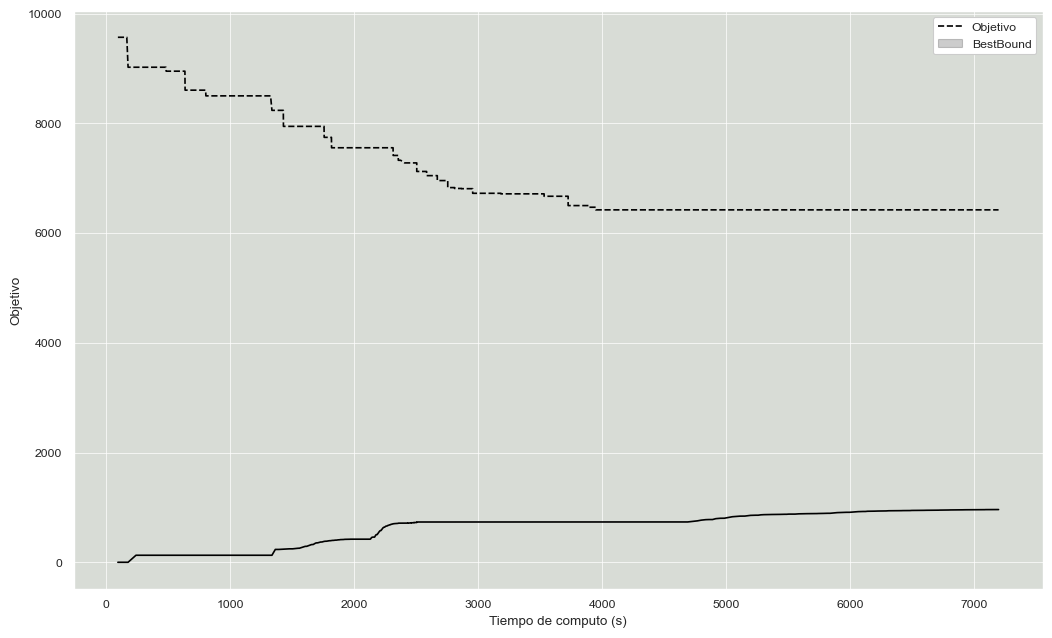

In [54]:
# creates a plot with two lines, one for objective and dthe other for best bound
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(12.5,7.5))
# use clear grey color for the background
ax.set_facecolor('xkcd:light grey')

# plot a grid
# use dashed black lines for the Objective line
sns.set_style("darkgrid")
sns.set_context("paper")
ax.grid(color='white', linestyle='-', linewidth=0.5)
sns.lineplot(data=df_cuad,x='Time',y='Objective',ax=ax,color='black',linestyle='dashed')
sns.lineplot(data=df_cuad,x='Time',y='BestBound',ax=ax,color='black')
# add a legend respecting the linestyles
# set xlabel and ylabel
ax.set_xlabel('Tiempo de computo (s)')
ax.set_ylabel('Objetivo')
ax.legend(['Objetivo','BestBound'],loc='upper right',frameon=True,facecolor='white',framealpha=1)
plt.show()



In [71]:
o1=sum(z[j1,j2].x*delta_semestre[j1,j2] for j1,j2 in product(J,J) if j1!=j2) 
o3=sum(z[j1,j2].x*delta_semestre[j1,j2]**2 for j1,j2 in product(J,J) if j1!=j2) 
o4=sum(z[j1,j2].x*1 for j1,j2 in product(J,J) if j1!=j2 and delta_semestre[j1,j2]>=8)
(o1,o3,o4)

(1472.0, 8732.0, 8.0)

In [55]:
print('Time elapsed: %g' % m.Runtime)
# print the keys for the y variables that are equal to 1
for c,j,s in valid_keys:
    if y[c,j,s].x>=0.9:
        print("la clase",horas_curso[j[:9]]['ASIGNATURA'], " grupo ",j[10:] ," se imparte en un salón tipo ",c,"en el horario del ",actual_time[s]["slot"], " con una duración de ",horas_curso[j[:9]]['horas'], " horas")

Time elapsed: 7201.49
la clase Física_Mecánica  grupo  0  se imparte en un salón tipo  G en el horario del  Viernes 18:00  con una duración de  4  horas
la clase Electrotecnia_Industrial            grupo  0  se imparte en un salón tipo  G en el horario del  Jueves 16:00  con una duración de  3  horas
la clase Gestión_Tecnología_Innovación  grupo  0  se imparte en un salón tipo  G en el horario del  Martes 19:00  con una duración de  3  horas
la clase OCP-I_Gestión_Procesos   grupo  0  se imparte en un salón tipo  G en el horario del  Miercoles 19:00  con una duración de  3  horas
la clase Mercadeo  grupo  0  se imparte en un salón tipo  G en el horario del  Jueves 19:00  con una duración de  3  horas
la clase Logística_Industrial  grupo  0  se imparte en un salón tipo  G en el horario del  Miercoles 16:00  con una duración de  3  horas
la clase ElectivaCFH-II_Ciencia_Tecnologia_Cultura  grupo  0  se imparte en un salón tipo  G en el horario del  Viernes 16:00  con una duración de  2  h

In [56]:
required_classrooms_by_tipe = {i:0 for i in tipo_salon}
schedule_grid = {}

for c,j,s in valid_keys:
    if y[c,j,s].x>=0.9:
        # check if the classroom is already in the schedule
        if required_classrooms_by_tipe[c]==0:
            required_classrooms_by_tipe[c]+=1
            # initialize the schedule grid for the classroom with all the days and hours in null
            schedule_grid[str(c)+"-"+str(1)] = {(actual_time[s2]["slot"].split(" ")[0],actual_time[s2]["slot"].split(" ")[1]): None for s2 in actual_time.keys()}
            for s2 in range(horas_curso[j[:9]]['horas']):
                schedule_grid[str(c)+"-"+str(1)][(actual_time[s+s2]["slot"].split(" ")[0],actual_time[s+s2]["slot"].split(" ")[1])] =str(ubicacion_semestral[j[:9]]["Semestre"])+"-" +horas_curso[j[:9]]['ASIGNATURA']+"-"+(names[pairs_dict[j]] if pairs_dict[j] in names.keys() else str(pairs_dict[j]))
                # split string on space

        else:
            # checks wheter the classrooms is available for the course hours, if so it adds the course to the schedule otherwise it adds a new classroom
            for i in range(1,required_classrooms_by_tipe[c]+1):
                fits = True
                for s2 in range(horas_curso[j[:9]]['horas']):
                    if schedule_grid[str(c)+"-"+str(i)][(actual_time[s+s2]["slot"].split(" ")[0],actual_time[s+s2]["slot"].split(" ")[1])] != None:
                        fits = False
                        break
                if fits:
                    for s2 in range(horas_curso[j[:9]]['horas']):
                        schedule_grid[str(c)+"-"+str(i)][(actual_time[s+s2]["slot"].split(" ")[0],actual_time[s+s2]["slot"].split(" ")[1])] = str(ubicacion_semestral[j[:9]]["Semestre"])+"-"+horas_curso[j[:9]]['ASIGNATURA']+"-"+(names[pairs_dict[j]] if pairs_dict[j] in names.keys() else str(pairs_dict[j]))
                    break
                elif i == required_classrooms_by_tipe[c]:
                    required_classrooms_by_tipe[c]+=1
                    schedule_grid[str(c)+"-"+str(required_classrooms_by_tipe[c])] = {(actual_time[s2]["slot"].split(" ")[0],actual_time[s2]["slot"].split(" ")[1]): None for s2 in actual_time.keys()}
                    for s2 in range(horas_curso[j[:9]]['horas']):
                        schedule_grid[str(c)+"-"+str(i+1)][(actual_time[s+s2]["slot"].split(" ")[0],actual_time[s+s2]["slot"].split(" ")[1])] = str(ubicacion_semestral[j[:9]]["Semestre"])+"-"+horas_curso[j[:9]]['ASIGNATURA']+"-"+(names[pairs_dict[j]] if pairs_dict[j] in names.keys() else str(pairs_dict[j]))
                    break
required_classrooms_by_tipe                    

{'G': 1, 'F': 1, 'C': 1, 'A': 0, 'D': 0, 'E': 0, 'B': 1}

In [57]:
import pandas as pd
list_dfs=[]
# present the actual time data as an square matrix
for sal in required_classrooms_by_tipe.keys():
    for slot in range(1,required_classrooms_by_tipe[sal]+1):
        sal_name=str(sal)+'-'+str(slot)
        

        df=[]

        for h in range(DAY_LENGTH):
            df_line=[sal_name]
            df_line.append(str(h+6)+':00')
            for d in DAYS:
                #print(schedule_grid[sal_name].keys())
                if sal_name in schedule_grid.keys() and (d,str(h+6)+':00') in schedule_grid[sal_name].keys() and schedule_grid[sal_name][(d,str(h+6)+':00')] is not None:
                    df_line.append(schedule_grid[sal_name][(d,str(h+6)+':00')].replace('_',' '))
                else:
                    df_line.append("-")
            
            df.append(df_line)
        df=pd.DataFrame(df,columns=["classroom",'time']+DAYS)
        # save to an excel file app
        list_dfs.append(df)
        display(df)

df=pd.concat(list_dfs)
df.to_excel("schedule_cuad.xlsx",index=False)
# print dataframe to pdf

df.to_html("schedule_cuad.html",index=False)
# print dataframe to pdf
"""from weasyprint import HTML
HTML(filename='schedule.html').write_pdf("schedule.pdf")"""


,classroom,time,Lunes,Martes,Miercoles,Jueves,Viernes
0,G-1,6:00,-,-,-,-,-
1,G-1,7:00,-,-,-,-,-
2,G-1,8:00,-,-,-,-,-
3,G-1,9:00,-,-,-,-,-
4,G-1,10:00,-,-,-,-,-
5,G-1,11:00,-,-,-,-,-
6,G-1,12:00,-,-,-,-,-
7,G-1,13:00,-,-,-,-,-
8,G-1,14:00,-,-,-,-,-
9,G-1,15:00,-,-,-,-,-


,classroom,time,Lunes,Martes,Miercoles,Jueves,Viernes
0,F-1,6:00,-,-,-,-,-
1,F-1,7:00,-,-,-,-,-
2,F-1,8:00,-,-,-,-,-
3,F-1,9:00,-,-,-,-,-
4,F-1,10:00,-,-,-,-,-
5,F-1,11:00,-,-,-,-,-
6,F-1,12:00,-,-,-,-,-
7,F-1,13:00,-,-,-,-,-
8,F-1,14:00,-,-,-,-,-
9,F-1,15:00,-,-,-,-,-


,classroom,time,Lunes,Martes,Miercoles,Jueves,Viernes
0,C-1,6:00,-,-,1-Fundamentos dibujo CAD-234541,-,-
1,C-1,7:00,-,-,1-Fundamentos dibujo CAD-234541,8-Investigación Operativa-437130,-
2,C-1,8:00,5-Modelos Regresón Series Tiempo-Andres Felipe...,-,-,8-Investigación Operativa-437130,5-Costos Presupuestos-Pedro Nel Barbosa Garcia
3,C-1,9:00,5-Modelos Regresón Series Tiempo-Andres Felipe...,6-Planeación Control Producción-Alvaro Jose To...,-,8-Investigación Operativa-437130,5-Costos Presupuestos-Pedro Nel Barbosa Garcia
4,C-1,10:00,5-Modelos Regresón Series Tiempo-Andres Felipe...,6-Planeación Control Producción-Alvaro Jose To...,8-Gerencia Proyectos-Edwin Javier Ortega Zuñiga,8-Investigación Operativa-437130,5-Costos Presupuestos-Pedro Nel Barbosa Garcia
5,C-1,11:00,5-Modelos Regresón Series Tiempo-Andres Felipe...,6-Planeación Control Producción-Alvaro Jose To...,8-Gerencia Proyectos-Edwin Javier Ortega Zuñiga,-,5-Costos Presupuestos-Pedro Nel Barbosa Garcia
6,C-1,12:00,-,6-Planeación Control Producción-Alvaro Jose To...,8-Gerencia Proyectos-Edwin Javier Ortega Zuñiga,9-Simulación-Jairo Arboleda Zuñiga,1-Fundamentos dibujo CAD-234541
7,C-1,13:00,-,-,6-Ingeniería Económica-Mariela Galindo,9-Simulación-Jairo Arboleda Zuñiga,1-Fundamentos dibujo CAD-234541
8,C-1,14:00,-,-,6-Ingeniería Económica-Mariela Galindo,9-Simulación-Jairo Arboleda Zuñiga,-
9,C-1,15:00,6-Diseño Experimental-Edwin Fernando Restrepo ...,7-Optimización-Jairo Arboleda Zuñiga,6-Ingeniería Económica-Mariela Galindo,9-Simulación-Jairo Arboleda Zuñiga,-


,classroom,time,Lunes,Martes,Miercoles,Jueves,Viernes
0,B-1,6:00,-,-,2-Economía-Marino Renjifo,-,5-Metodología Investigación-Edwin Fernando Res...
1,B-1,7:00,-,-,2-Economía-Marino Renjifo,4-Ecuaciones Diferenciales-Andres Felipe Parra...,5-Metodología Investigación-Edwin Fernando Res...
2,B-1,8:00,4-Probabilidad Inferencia Estadistica-Andres F...,-,-,4-Ecuaciones Diferenciales-Andres Felipe Parra...,2-Fundamentos Quimica-Yaqueline Quiñones Rodri...
3,B-1,9:00,4-Probabilidad Inferencia Estadistica-Andres F...,7-Diseño Mantenimiento Plantas -Alvaro Jose T...,-,4-Ecuaciones Diferenciales-Andres Felipe Parra...,2-Fundamentos Quimica-Yaqueline Quiñones Rodri...
4,B-1,10:00,4-Probabilidad Inferencia Estadistica-Andres F...,7-Diseño Mantenimiento Plantas -Alvaro Jose T...,5-ElectivaCFH-I Catedra sostenibilidad-Edwin J...,4-Ecuaciones Diferenciales-Andres Felipe Parra...,2-Fundamentos Quimica-Yaqueline Quiñones Rodri...
5,B-1,11:00,4-Probabilidad Inferencia Estadistica-Andres F...,7-Diseño Mantenimiento Plantas -Alvaro Jose T...,5-ElectivaCFH-I Catedra sostenibilidad-Edwin J...,5-ElectivaCFH-I Catedra sostenibilidad-Edwin J...,2-Fundamentos Quimica-Yaqueline Quiñones Rodri...
6,B-1,12:00,3-Cálculo Vectorial-Andres Felipe Parra Perea,7-Diseño Mantenimiento Plantas -Alvaro Jose T...,2-Economía-Marino Renjifo,5-ElectivaCFH-I Catedra sostenibilidad-Edwin J...,3-Legislación-William Andres Alzate Cobo
7,B-1,13:00,3-Cálculo Vectorial-Andres Felipe Parra Perea,9-Contexto Profesional-Beatriz Elena Hernandez...,2-Economía-Marino Renjifo,1-Calculo Diferencial-Andres Felipe Parra Perea,3-Legislación-William Andres Alzate Cobo
8,B-1,14:00,3-Cálculo Vectorial-Andres Felipe Parra Perea,9-Contexto Profesional-Beatriz Elena Hernandez...,4-Procesos Industriales-Alvaro Jose Torres Pen...,1-Calculo Diferencial-Andres Felipe Parra Perea,1-Introducción Ingeniería Industrial-William A...
9,B-1,15:00,3-Cálculo Vectorial-Andres Felipe Parra Perea,3-Materiales Ingeniería-Yaqueline Quiñones Rod...,4-Procesos Industriales-Alvaro Jose Torres Pen...,1-Calculo Diferencial-Andres Felipe Parra Perea,1-Introducción Ingeniería Industrial-William A...


'from weasyprint import HTML\nHTML(filename=\'schedule.html\').write_pdf("schedule.pdf")'